# ======================== 05-1 결정트리 ========================

---
layout: single
title:  "CHAPTER 05"
categories: AI
---

In [1]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [2]:
# 열의 데이터타입과 누락된 데이터 확인
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [3]:
# 열에 대한 간단한 통계 출력
wine.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [4]:
# 데이터프레임을 넘파이 배열로 변환
data = wine[['alcohol','sugar','pH']].to_numpy()
target = wine['class'].to_numpy()

In [5]:
# 사이킷런을 통해 훈련세트와 테스트세트 분류
#  test_size=0.2 : 20%를 테스트 세트로 지정
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2 ,random_state=42)

In [6]:
# 훈련세트, 테스트세트 데이터 수,열의 수 확인
print(train_input.shape, test_input.shape)

(5197, 3) (1300, 3)


In [7]:
# 훈련세트 특성표준화 전처리
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

로지스틱 회귀 모델 훈련

In [8]:
# 로지스틱 회귀 모델 훈련
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target)) # 훈련세트
print(lr.score(test_scaled, test_target))   # 테스트세트
#훈련세트와 테스트세트 점수가 낮다 : 과소적합

0.7808350971714451
0.7776923076923077


In [9]:
# 로지스틱 회귀모델 계수와 절편
print(lr.coef_, lr.intercept_)

[[ 0.51270274  1.6733911  -0.68767781]] [1.81777902]


결정트리 모델 훈련

In [10]:
# 결정트리 모델 훈련
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target)) # 훈련세트
print(dt.score(test_scaled, test_target))   # 테스트세트

0.996921300750433
0.8584615384615385


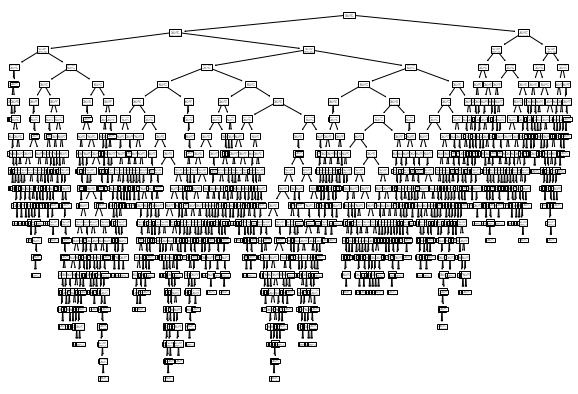

In [11]:
# 결정트리 모델 시각화
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(10,7))
plot_tree(dt)
plt.show()

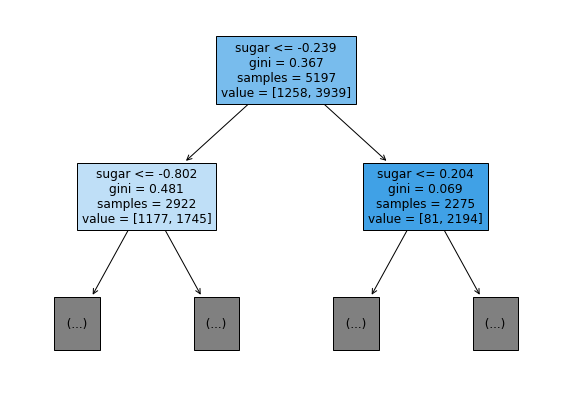

In [12]:
# 트리의 깊이를 제한해서 출력
plt.figure(figsize=(10,7))
plot_tree(dt, max_depth=1, filled=True, feature_names=['alcohol','sugar','pH'])
plt.show()

In [13]:
# 루트노드 아래로 최대 3개 노드까지만 성장
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target)) # 훈련세트
print(dt.score(test_scaled, test_target))   # 테스트세트

0.8454877814123533
0.8415384615384616


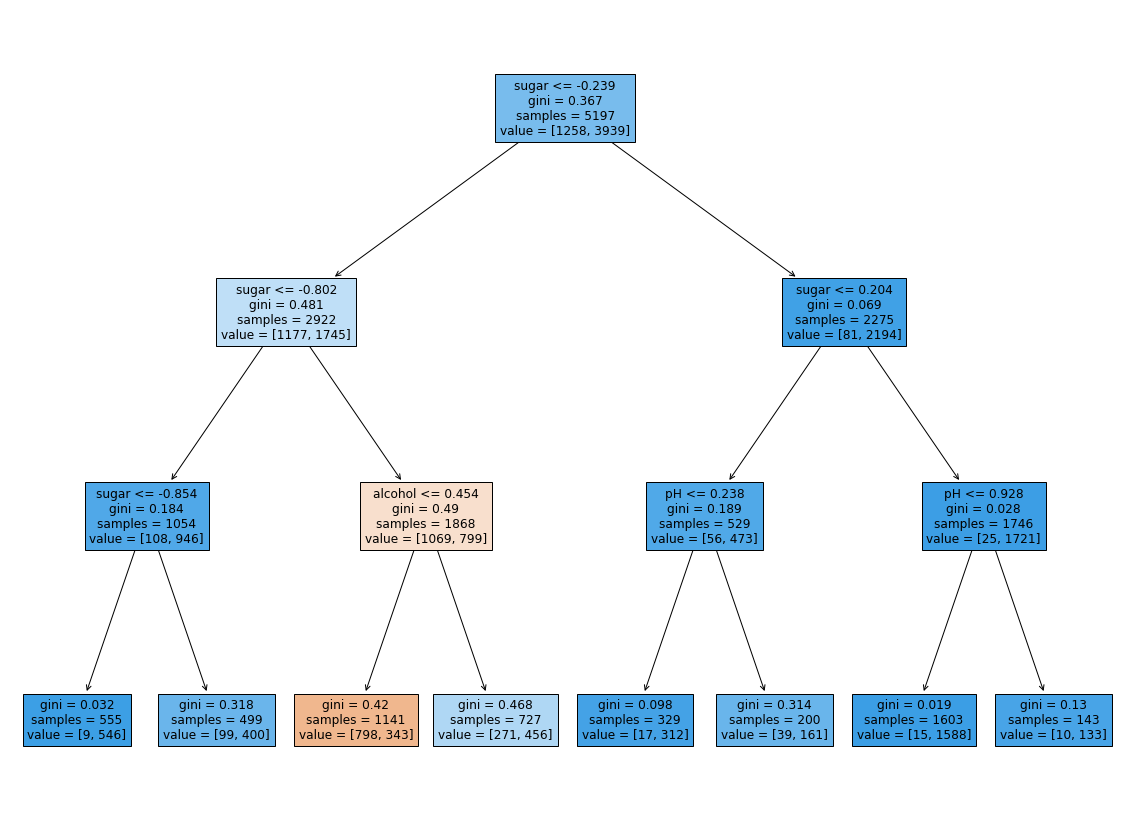

In [14]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol','sugar','pH'])
plt.show()

In [15]:
# 결정트리는 표준화 전처리 과정이 필요없다.
# 루트노드 아래로 최대 3개 노드까지만 성장
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_input, train_target)) # 훈련세트
print(dt.score(test_input, test_target))   # 테스트세트

0.7579372715027901
0.7376923076923076


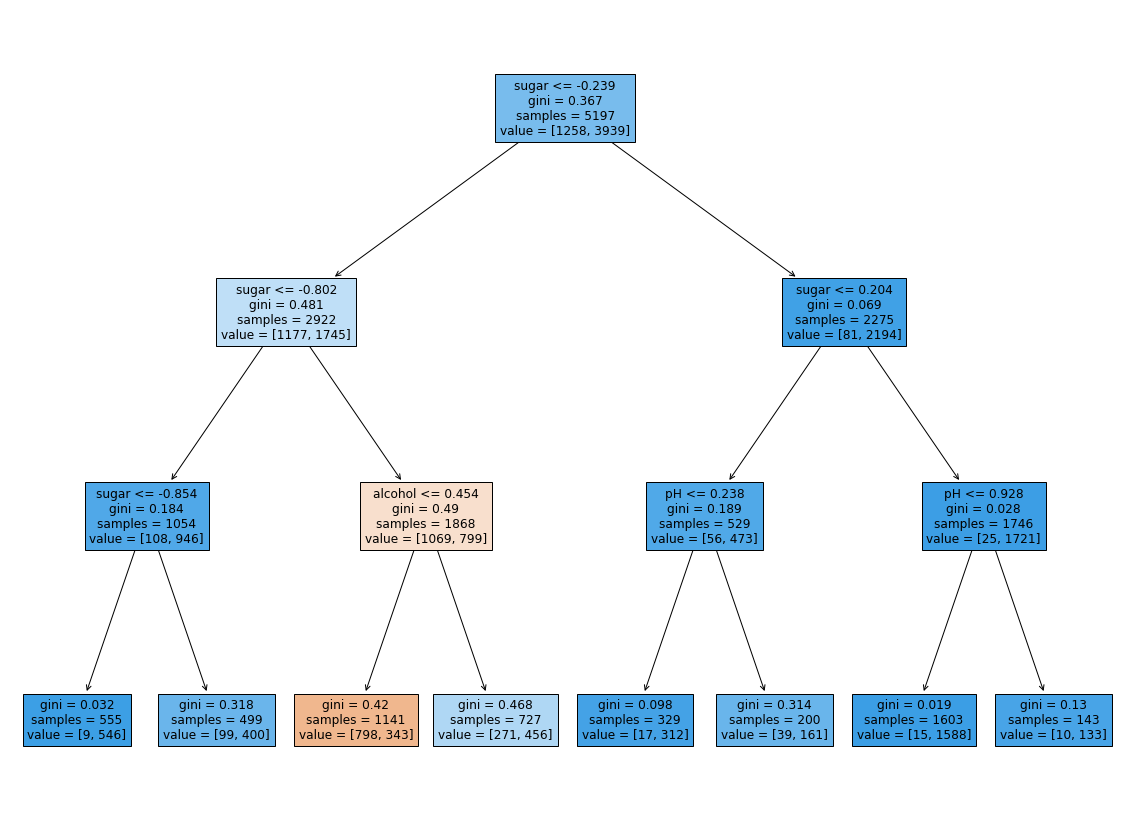

In [16]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol','sugar','pH'])
plt.show()

In [17]:
print(dt.feature_importances_)

[0.12345626 0.86862934 0.0079144 ]


# ====================== 05-2 교차 검증과 그리드 서치 ======================

In [18]:
# Wine데이터 준비

import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [19]:
# class열을 타깃으로 사용
# 나머지 열은 특성 배열에 저장

data = wine[['alcohol','sugar','pH']].to_numpy()
target = wine['class'].to_numpy()

In [20]:
# 사이킷런을 통해 훈련세트와 테스트세트 분류
# test_size=0.2 : 20%를 테스트 세트로 지정

from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2,random_state=42)
print('train_input :',train_input.shape,'\n',train_input,'\n','test_input :',test_input.shape,'\n',test_input)

train_input : (5197, 3) 
 [[10.5   7.7   3.19]
 [12.4   2.1   3.26]
 [11.8   2.1   3.41]
 ...
 [ 9.5   5.6   3.24]
 [ 9.5   8.    3.18]
 [ 9.5   2.7   3.51]] 
 test_input : (1300, 3) 
 [[12.2  12.8   3.26]
 [ 9.9   2.2   3.27]
 [12.    7.4   3.18]
 ...
 [12.4   1.8   3.19]
 [ 9.4   9.7   3.3 ]
 [ 8.7  15.5   2.9 ]]


In [21]:
# train set을 다시 훈련세트와 검증세트로 나눔
sub_input, val_input, sub_target, val_target = train_test_split(train_input, train_target, test_size=0.2,random_state=42)

# 훈련세트와 검증세트 크기 확인
print('sub_input :',sub_input.shape,'\n',sub_input,'\n','val_input :',val_input.shape,'\n',val_input)

sub_input : (4157, 3) 
 [[11.4   1.25  2.95]
 [ 9.1   8.    3.23]
 [ 9.1  13.4   3.06]
 ...
 [11.5   3.    3.16]
 [12.3   9.    3.13]
 [11.1   1.4   3.34]] 
 val_input : (1040, 3) 
 [[11.3   2.5   3.38]
 [11.4   1.8   3.18]
 [12.2   2.4   3.2 ]
 ...
 [10.6  15.8   3.24]
 [ 9.5   2.4   3.18]
 [10.    9.    3.34]]


In [22]:
# 결정트리 모델 훈련
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

# 훈련결과 : 과대적합
print(dt.score(sub_input, sub_target)) # 훈련세트
print(dt.score(val_input, val_target)) # 테스트세트

0.9971133028626413
0.864423076923077


In [23]:
# 교차 검증
from sklearn.model_selection import cross_validate

# cross_validate() : fit_time, score_time, test_score키를 가진 딕셔너리 반환
scores = cross_validate(dt, train_input, train_target)

# fit_time : 모델을 훈련하는 시간
print('fit_time(모델을 훈련하는 시간)   : ',scores['fit_time'])
# score_time : 모델을 검증하는 시간
print('score_time(모델을 검증하는 시간) : ',scores['score_time'])
# test_score : 교차 검증의 최종점수
print('test_score(교차 검증의 최종점수) : ',scores['test_score'])

fit_time(모델을 훈련하는 시간)   :  [0.00999427 0.00899625 0.01001096 0.00899506 0.00899434]
score_time(모델을 검증하는 시간) :  [0.00099897 0.00100112 0.00100017 0.00100541 0.00100636]
test_score(교차 검증의 최종점수) :  [0.86923077 0.84615385 0.87680462 0.84889317 0.83541867]


In [24]:
# 교차 검증 점수
import numpy as np
print(np.mean(scores['test_score']))

0.855300214703487


In [25]:
from sklearn.model_selection import StratifiedKFold
score = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(score['test_score']))

0.855300214703487


In [26]:
#훈련세트 섞은 후 교차검증

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
sclre = cross_validate(dt, train_input,train_target, cv=splitter)
print(np.mean(score['test_score']))

0.855300214703487


In [27]:
# 그리드 서치
# 0.0001 부터 0.0005까지 0.0001씩 증가하는 5개값으로 시도
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease' : [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [28]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [29]:
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [30]:
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [31]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


In [32]:
params = {'min_impurity_decrease':np.arange(0.0001, 0.001, 0.0001),
          'max_depth':range(5, 20, 1),
          'min_samples_split':range(2,100,10)}

In [33]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [34]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [35]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


In [36]:
from scipy.stats import uniform, randint
rgen = randint(0,10)
rgen.rvs(10)

array([1, 9, 6, 8, 6, 3, 4, 4, 9, 1])

In [37]:
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 92,  89, 103,  95,  99, 108, 101,  89, 116, 108], dtype=int64))

In [38]:
ugen = uniform(0,1)
ugen.rvs(10)

array([0.92421665, 0.59494774, 0.78449118, 0.02123036, 0.23072076,
       0.60536641, 0.13079389, 0.46139579, 0.84059405, 0.73791246])

In [39]:
params = {'min_impurity_decrease':np.arange(0.0001, 0.001),
          'max_depth':range(20, 50),
          'min_samples_split':range(2,25),
          'min_samples_leaf':range(1,25)}

In [40]:
from sklearn.model_selection import RandomizedSearchCV
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))

{'min_samples_split': 8, 'min_samples_leaf': 23, 'min_impurity_decrease': 0.0001, 'max_depth': 35}
0.8683852817057822


In [41]:
dt = gs.best_estimator_
print(dt.score(test_input, test_target))

0.8576923076923076


# ====================== 05-3 트리의 앙상블 ======================

In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

wine = pd.read_csv('https://bit.ly/wine_csv_data')
print('Wine Data \n',wine.head(),'\n\n')

data = wine[['alcohol','sugar','pH']].to_numpy()
print("alcohol, sugar, pH를 numpy배열로 변환 후 data에 저장 \n",data.shape,'\n',data,'\n\n')

target = wine['class'].to_numpy()
print("class를 numpy배열로 변환 후 target에 저장 :",target.shape,'\n',target,'\n\n')

print("sklearn을 이용하여 data와 target을 train, test세트 분류\n")
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2,random_state=42)
print('train_input :',train_input.shape,'\n',train_input,'\n','test_input :',test_input.shape,'\n',test_input,'\n\n')

# 랜덤포레스트
print("랜덤포레스트를 이용한 교차 검증 점수 확인")
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']),'\n\n')

rf.fit(train_input, train_target)
print('랜덤 포레스트 모델을 훈련한 train세트의 특성 중요도\n alcohol,     sugar,     pH\n',rf.feature_importances_,'\n당도점수가 높다\n\n ')

print("train세트로 훈련하여 OOB 점수 출력...")
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)
rf.fit(train_input, train_target)
print("OOB SCORE :",rf.oob_score_,'\n\n')

# 엑스트라 트리
print("엑스트라 트리로 모델 교차 검증 점수 확인 ")
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(n_jobs=-1, random_state=42)
score = cross_validate(et, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']),np.mean(scores['test_score']),'\n\n')

print("엑스트라 트리로 훈련한 train세트의 특성 중요도\n alcohol,     sugar,     pH")
et.fit(train_input, train_target)
print(et.feature_importances_)

# 그라이언트 부스팅
print("그레이디언트 부스팅을 이용해 와인 데이터셋의 교차 검증 점수 확인")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']),'\n\n')

print("성능향상을 위해 학습률증가 및 트리개수 증가 후 점수 확인")
gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.2,random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']),'\n\n')

print("그레이디언트 부스팅으로 훈련한 train세트의 특성 중요도\n alcohol,     sugar,     pH")
gb.fit(train_input, train_target)
print(gb.feature_importances_,'\n\n')

# 히스토그램 기반 그레이디언트 부스팅
print("히스토그램 기반 그레이디언트 부스팅을 이용한 검증점수 확인")
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, train_input, train_target, return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']),'\n\n')

print("히스토그램 기반 그레이디언트 부스팅으로 훈련한 train세트의 특성 중요도\n alcohol,     sugar,     pH")
from sklearn.inspection import permutation_importance
hgb.fit(train_input, train_target)
result = permutation_importance(hgb, train_input, train_target, n_repeats=10, random_state=42, n_jobs=-1)
print(result.importances_mean,'\n\n')

print("히스토그램 기반 그레이디언트 부스팅으로 훈련한 test세트의 특성 중요도\n alcohol,     sugar,     pH")
result = permutation_importance(hgb, test_input, test_target, n_repeats=10, random_state=42, n_jobs=-1)
print(result.importances_mean,'\n\n')

print("테스트세트의 성능 최종 확인")
hgb.score(test_input, test_target)

print("XGBoost를 사용해 와인 데이터의 교차 검증 점수 확인")
from xgboost import XGBClassifier
xgb = XGBClassifier(tree_method='hist', random_state=42)
scores = cross_validate(xgb, train_input, train_target, return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']),'\n\n')

print("LightGBM를 사용해 와인 데이터의 교차 검증 점수 확인")
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state=42)
scores = cross_validate(lgb, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']),'\n\n')

Wine Data 
    alcohol  sugar    pH  class
0      9.4    1.9  3.51    0.0
1      9.8    2.6  3.20    0.0
2      9.8    2.3  3.26    0.0
3      9.8    1.9  3.16    0.0
4      9.4    1.9  3.51    0.0 


alcohol, sugar, pH를 numpy배열로 변환 후 data에 저장 
 (6497, 3) 
 [[ 9.4   1.9   3.51]
 [ 9.8   2.6   3.2 ]
 [ 9.8   2.3   3.26]
 ...
 [ 9.4   1.2   2.99]
 [12.8   1.1   3.34]
 [11.8   0.8   3.26]] 


class를 numpy배열로 변환 후 target에 저장 : (6497,) 
 [0. 0. 0. ... 1. 1. 1.] 


sklearn을 이용하여 data와 target을 train, test세트 분류

train_input : (5197, 3) 
 [[10.5   7.7   3.19]
 [12.4   2.1   3.26]
 [11.8   2.1   3.41]
 ...
 [ 9.5   5.6   3.24]
 [ 9.5   8.    3.18]
 [ 9.5   2.7   3.51]] 
 test_input : (1300, 3) 
 [[12.2  12.8   3.26]
 [ 9.9   2.2   3.27]
 [12.    7.4   3.18]
 ...
 [12.4   1.8   3.19]
 [ 9.4   9.7   3.3 ]
 [ 8.7  15.5   2.9 ]] 


랜덤포레스트를 이용한 교차 검증 점수 확인
0.9973541965122431 0.8905151032797809 


랜덤 포레스트 모델을 훈련한 train세트의 특성 중요도
 alcohol,     sugar,     pH
 [0.23167441 0.50039841 0.26792718] 
당도점수가 높다

ModuleNotFoundError: No module named 'xgboost'